In [1]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
!unzip /content/drive/MyDrive/faces.zip -d /content/drive/MyDrive/faces

unzip:  cannot find or open /content/drive/MyDrive/faces.zip, /content/drive/MyDrive/faces.zip.zip or /content/drive/MyDrive/faces.zip.ZIP.


In [5]:
import os
import cv2
import glob
import imageio
import numpy as np
import pandas as pd
import PIL.Image
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.patches import Rectangle
from matplotlib.animation import FuncAnimation
from random import randint
import tensorflow as tf
from IPython.display import Image, display
%matplotlib inline

# Agumentation

In [ ]:
def make_salt_and_pepper(data):
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            value = randint(0, 50)
            if (value > 0 and value <= 1):
                data[i, j] = 0
            elif (value > 1 and value <= 2):
                data[i, j] = 255
            else:
                data[i, j] = data[i, j]
    return data

In [ ]:
def make_gaussian(image):
  noised_image = image + 3 * image.std() * np.random.random(image.shape)
  return noised_image

In [ ]:
for i in range(500):
  path = "/content/drive/My Drive/faces/with_mask/"+str(i)+"-with-mask.jpg"
  if os.path.isfile(path):
    data = np.array(PIL.Image.open(path).convert('RGB'))
    new_data = make_salt_and_pepper(data)
    cv2.imwrite(("/content/drive/My Drive/faces/with_mask/"+str(i)+"-with-mask-saltandpepper.jpg"), cv2.cvtColor(new_data, cv2.COLOR_RGB2BGR))

In [ ]:
for i in range(500):
  path = "/content/drive/My Drive/faces/without_mask/"+str(i)+".jpg"
  if os.path.isfile(path):
    data = np.array(PIL.Image.open(path).convert('RGB'))
    new_data = make_salt_and_pepper(data)
    cv2.imwrite(("/content/drive/My Drive/faces/without_mask/"+str(i)+"-without-mask-saltandpepper.jpg"), cv2.cvtColor(new_data, cv2.COLOR_RGB2BGR))

In [ ]:
for i in range(500):
  path = "/content/drive/My Drive/faces/with_mask/"+str(i)+"-with-mask.jpg"
  if os.path.isfile(path):
    data = cv2.imread(path,1)
    new_data = make_gaussian(data)
    cv2.imwrite(("/content/drive/My Drive/faces/with_mask/"+str(i)+"-with-mask-gaussian.jpg"), new_data)

In [ ]:
for i in range(500):
  path = "/content/drive/My Drive/faces/without_mask/"+str(i)+".jpg"
  if os.path.isfile(path):
    data = cv2.imread(path,1)
    new_data = make_gaussian(data)
    cv2.imwrite(("/content/drive/My Drive/faces/without_mask/"+str(i)+"-without-mask-gaussian.jpg"), new_data)

# Preprocessing 

In [3]:
def resize_image(src_img, size=(227,227), bg_color="white"): 
    # rescale the image so the longest edge is the right size
    src_img.thumbnail(size, PIL.Image.ANTIALIAS)
    # Create a new image of the right shape
    new_image = PIL.Image.new("RGB", size, bg_color)
    # Paste the rescaled image onto the new centered background
    new_image.paste(src_img, (int((size[0] - src_img.size[0]) / 2), int((size[1] - src_img.size[1]) / 2)))
    # return the resized image
    return new_image


def resize_image_caller(first,second):
  # get the list of test image files
  test_folder = first
  test_image_files = os.listdir(test_folder)

  # Empty array on which to store the images
  image_arrays = []
  size = (227,227)
  background_color="white"

  # Get the images
  for file_idx in range(len(test_image_files)):
      img = PIL.Image.open(os.path.join(test_folder, test_image_files[file_idx]))
      # resize the image
      resized_img = np.array(resize_image(img, size, background_color))
      # Add the image to the array of images
      image_arrays.append(resized_img)

  for i in range(len(image_arrays)):
    cv2.imwrite((second+str(i)+".jpg"), image_arrays[i])

In [ ]:
!mkdir /content/drive/MyDrive/newfaces
!mkdir /content/drive/MyDrive/newfaces/with_mask
!mkdir /content/drive/MyDrive/newfaces/without_mask
!rmdir /content/drive/MyDrive/faces/with_mask/.ipynb_checkpoints
!rmdir /content/drive/MyDrive/faces/without_mask/.ipynb_checkpoints

mkdir: cannot create directory ‘/content/drive/MyDrive/newfaces’: No such file or directory
mkdir: cannot create directory ‘/content/drive/MyDrive/newfaces/with_mask’: No such file or directory
mkdir: cannot create directory ‘/content/drive/MyDrive/newfaces/without_mask’: No such file or directory
rmdir: failed to remove '/content/drive/MyDrive/faces/with_mask/.ipynb_checkpoints': No such file or directory
rmdir: failed to remove '/content/drive/MyDrive/faces/without_mask/.ipynb_checkpoints': No such file or directory


In [6]:
resize_image_caller("/content/drive/My Drive/faces/with_mask/","/content/drive/My Drive/newfaces/with_mask/")
resize_image_caller("/content/drive/My Drive/faces/without_mask/","/content/drive/My Drive/newfaces/without_mask/")

# Classification


In [ ]:
# Convolutional Neural Network

# Installing Theano
# pip install --upgrade --no-deps git+git://github.com/Theano/Theano.git

# Installing Tensorflow
# Install Tensorflow from the website: https://www.tensorflow.org/versions/r0.12/get_started/os_setup.html

# Installing Keras
# pip install --upgrade keras

# Part 1 - Building the CNN

# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

# Initialising the CNN
classifier = Sequential()

# Step 1 - Convolution
classifier.add(Convolution2D(32, 3, 3, input_shape = (227, 227, 3), activation = 'relu'))

# Step 2 - Pooling
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Adding a second convolutional layer
classifier.add(Convolution2D(32, 3, 3, activation = 'relu'))
classifier.add(MaxPooling2D(pool_size = (2, 2)))

# Step 3 - Flattening
classifier.add(Flatten())

# Step 4 - Full connection
classifier.add(Dense(128, activation = 'relu'))
classifier.add(Dense(1, activation = 'sigmoid'))

# Compiling the CNN
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])

# Part 2 - Fitting the CNN to the images

from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/drive/My Drive/newfaces',
                                                 target_size = (227, 227),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('/content/drive/My Drive/newfaces',
                                            target_size = (227, 227),
                                            batch_size = 32,
                                            class_mode = 'binary')

classifier.fit(training_set,
                        epochs=10,
                        validation_data = test_set
                        )

Found 3008 images belonging to 2 classes.
Found 3008 images belonging to 2 classes.
Epoch 1/10
94/94 [==============================] - 567s 6s/step - loss: 0.6230 - accuracy: 0.6071 - val_loss: 0.2572 - val_accuracy: 0.9082
Epoch 2/10
94/94 [==============================] - 64s 677ms/step - loss: 0.2440 - accuracy: 0.9071 - val_loss: 0.1991 - val_accuracy: 0.9215
Epoch 3/10
94/94 [==============================] - 63s 676ms/step - loss: 0.1561 - accuracy: 0.9472 - val_loss: 0.1444 - val_accuracy: 0.9395
Epoch 4/10
94/94 [==============================] - 63s 670ms/step - loss: 0.1576 - accuracy: 0.9453 - val_loss: 0.1104 - val_accuracy: 0.9568
Epoch 5/10
94/94 [==============================] - 63s 673ms/step - loss: 0.1228 - accuracy: 0.9454 - val_loss: 0.1051 - val_accuracy: 0.9591
Epoch 6/10
94/94 [==============================] - 63s 668ms/step - loss: 0.1290 - accuracy: 0.9513 - val_loss: 0.1080 - val_accuracy: 0.9581
Epoch 7/10
94/94 [==============================] - 62s 663m

# Test

## Noise Reduction


In [ ]:
def median_(data):
    array = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            array.append(data[i, j][0]+data[i, j][1]+data[i, j][2])
    array.sort()
    med = array[(int)(len(array) / 2)]
    return med

def median(image):
    data = np.array(Image.open(image).convert('L'))
    w = 2
    m = data.shape[0]
    n = data.shape[1]
    img_new = np.zeros([m, n,3])
    for i in range(2, m):
        for j in range(2, n):
          if data[i, j][0]==0 and data[i, j][1]==0 and data[i, j][2]==0:
            img_new[i, j] = data[i-1, j] 
          elif data[i, j][0]==255 and data[i, j][1]==255 and data[i, j][2]==255:
            img_new[i, j] = data[i-1, j] 
          else:
            img_new[i, j] = data[i, j] 
    return img_new

def mean_(data):
    mean = 0
    for i in range(0, data.shape[0]):
        for j in range(0, data.shape[1]):
            mean += data[i][j]
    return mean / (data.shape[0] * data.shape[1])

def mean(image):
    data = np.array(Image.open(image).convert('L'))
    w = 2
    m = data.shape[0]
    n = data.shape[1]
    img_new = np.zeros([m, n])
    for i in range(2, m):
        for j in range(2, n):
            img_new[i, j] = mean_(data[i - w:i + w, j - w:j + w])
    img_new = img_new.astype(np.uint8)
    return img_new

def remove_noise(img):
  b,g,r = cv2.split(img)           
  rgb_img = cv2.merge([r,g,b])     
  dst = cv2.fastNlMeansDenoisingColored(img,None,10,10,7,21) 
  b,g,r = cv2.split(dst)          
  rgb_dst = cv2.merge([r,g,b])     
  cv2.imwrite(("removed"+path), rgb_dst)

In [ ]:
!rm -r /content/drive/MyDrive/test/without_mask
!mkdir /content/drive/MyDrive/test/without_mask
!rmdir /content/drive/MyDrive/test/without_mask/.ipynb_checkpoints
!rm -r /content/drive/MyDrive/test/with_mask
!mkdir /content/drive/MyDrive/test/with_mask
!rmdir /content/drive/MyDrive/test/with_mask/.ipynb_checkpoints
!rm -r /content/drive/MyDrive/test/.ipynb_checkpoints/
!shuf -zn35 -e /content/drive/MyDrive/newfaces/without_mask/*.jpg | xargs -0 mv -vt /content/drive/MyDrive/test/without_mask
!shuf -zn35 -e /content/drive/MyDrive/newfaces/with_mask/*.jpg | xargs -0 mv -vt /content/drive/MyDrive/test/with_mask

rmdir: failed to remove '/content/drive/MyDrive/test/without_mask/.ipynb_checkpoints': No such file or directory
rmdir: failed to remove '/content/drive/MyDrive/test/with_mask/.ipynb_checkpoints': No such file or directory
rm: cannot remove '/content/drive/MyDrive/test/.ipynb_checkpoints/': No such file or directory
renamed '/content/drive/MyDrive/newfaces/without_mask/1418.jpg' -> '/content/drive/MyDrive/test/without_mask/1418.jpg'
renamed '/content/drive/MyDrive/newfaces/without_mask/1245.jpg' -> '/content/drive/MyDrive/test/without_mask/1245.jpg'
renamed '/content/drive/MyDrive/newfaces/without_mask/839.jpg' -> '/content/drive/MyDrive/test/without_mask/839.jpg'
renamed '/content/drive/MyDrive/newfaces/without_mask/1094.jpg' -> '/content/drive/MyDrive/test/without_mask/1094.jpg'
renamed '/content/drive/MyDrive/newfaces/without_mask/1393.jpg' -> '/content/drive/MyDrive/test/without_mask/1393.jpg'
renamed '/content/drive/MyDrive/newfaces/without_mask/198.jpg' -> '/content/drive/MyDrive

In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255)
test_ds = test_datagen.flow_from_directory('/content/drive/My Drive/test',
                                                 target_size = (227, 227),
                                                 class_mode = 'binary',
                                           batch_size=70
                                           )

Found 70 images belonging to 2 classes.


In [ ]:
result = classifier.evaluate(test_ds)

1/1 [==============================] - 0s 366ms/step - loss: 0.0457 - accuracy: 1.0000


In [ ]:
predictions = classifier.predict(test_ds)

In [ ]:
images, labels = test_ds.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


28 28 170 170
face without mask detected!


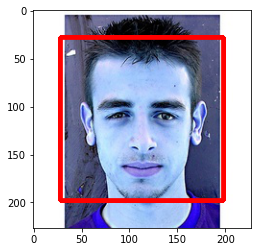

In [ ]:
i = 2
image = images[i].copy()
x = int(len(image)/8)
y = int(len(image[0])/8)
w = int(len(image)*3/4)
h = int(len(image[0])*3/4)
print(x, y, w, h)
if(predictions[i][0] > 0.5):
  print("face with mask detected!")
  cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),3) 
else:
  print("face without mask detected!")
  cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),3) 
plt.imshow(image)

In [ ]:
def nms(Et, angles):
  r = 45 / 2
  val = np.zeros(shape=(width, height))
  for i in range(1, width - 1):
    for j in range(1, height - 1):
      if (0 <= angles[i, j] < r) or ((135+r) <= angles[i, j] <= 180):
        val[i][j] = max(Et[i][j - 1], Et[i, j + 1])
      elif (r <= angles[i, j] < (45+r)):
        val[i][j] = max(Et[i - 1, j - 1], Et[i + 1, j + 1])
      elif ((45+r) <= angles[i, j] < (90+r)):
        val[i][j] = max(Et[i - 1, j], Et[i + 1, j])
      else:
        val[i][j] = max(Et[i + 1, j - 1], Et[i - 1, j + 1])

  nms_img = np.where(Et >= val, Et, 0)
  return nms_img

In [ ]:
def sobel(k):
  Kv = np.array([
                 [-1, 0, 1],
                 [-k, 0, k],
                 [-1, 0, 1]
  ]);
  Kh = Kv.T
  Ev = np.zeros((width, height))
  Eh = np.zeros((width, height))
  for i in range(1, width - 1):
        for j in range(1, height - 1):
          Ev[i, j] = np.sum(np.multiply(img[i - 1 : i + 2, j - 1 : j + 2], Kv))
          Eh[i, j] = np.sum(np.multiply(img[i - 1 : i + 2, j - 1 : j + 2], Kh))
  Et = np.sqrt(np.square(Ev) + np.square(Eh))
  angles = np.rad2deg(np.arctan2(Eh, Ev))
  angles[angles < 0] += 180
  return Et, angles 

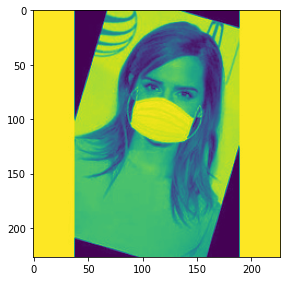

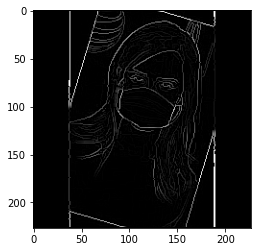

In [ ]:
#Edge detection test
image = images[35]
img = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(img)
plt.show()
width, height = img.shape
Et, angles = sobel(1.2)
nms_img = nms(Et, angles)

plt.imshow(nms_img, cmap=plt.get_cmap('gray'))
plt.show()

(1080, 1920, 3)

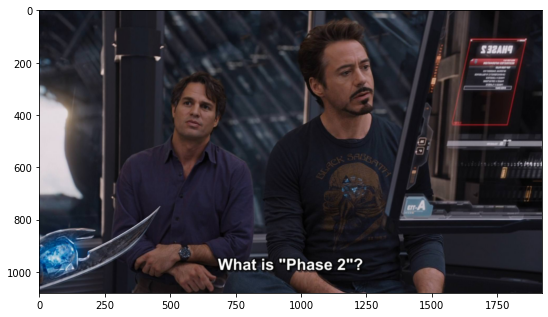

In [ ]:
img_address = "drive/My Drive/VM7AFvc.jpg"
image = cv2.imread(img_address)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

fig = plt.figure(figsize=(9,9))
plt.imshow(image)
image.shape

(962, 1300, 3)
(1080, 1920)


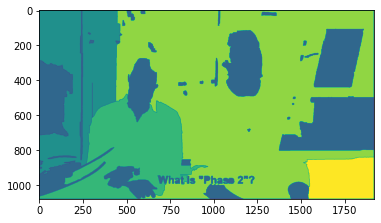

In [ ]:
img = cv2.imread("drive/My Drive/VM7AFvc.jpg")
print(image.shape)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
print(gray.shape)
ret, thresh = cv2.threshold(gray,0,255,cv2.THRESH_BINARY_INV+cv2.THRESH_OTSU)

# noise removal
kernel = np.ones((3,3),np.uint8)
opening = cv2.morphologyEx(thresh,cv2.MORPH_OPEN,kernel, iterations = 2)

# sure background area
sure_bg = cv2.dilate(opening,kernel,iterations=3)

# Finding sure foreground area
dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
ret, sure_fg = cv2.threshold(dist_transform,0.7*dist_transform.max(),255,0)

# Finding unknown region
sure_fg = np.uint8(sure_fg)
unknown = cv2.subtract(sure_bg,sure_fg)
# Marker labelling
ret, markers = cv2.connectedComponents(sure_fg)

# Add one to all labels so that sure background is not 0, but 1
markers = markers+1

# Now, mark the region of unknown with zero
markers[unknown==255] = 0
markers = cv2.watershed(img,markers)
img[markers == -1] = [255,0,0]
plt.imshow(markers)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


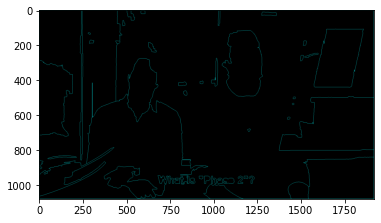

In [ ]:
tmp = np.zeros((len(img), len(img[0]), len(img[0][0])))
tmp[markers == -1] = [0,255, 255]
plt.imshow(tmp)

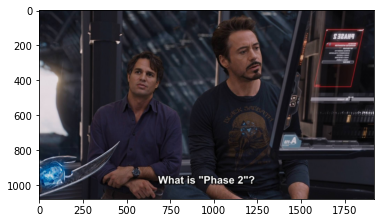

<Figure size 648x648 with 0 Axes>

In [ ]:
img_address = "drive/My Drive/VM7AFvc.jpg"
image = cv2.imread(img_address)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
fig = plt.figure(figsize=(9,9))
image.shape
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
faces = face_cascade.detectMultiScale(image, 1.2, 2)

image_with_detections = image.copy()
imgs = []
for (x,y,w,h) in faces:
  roi = image[y:y+h, x:x+w]
  imgs.append(roi)

scaled_image_1 = cv2.resize(imgs[0], (227, 227)) 
scaled_image_2 = cv2.resize(imgs[1], (227, 227))
news = []
news.append(scaled_image_1)
news.append(scaled_image_2)


In [ ]:
predictions = classifier.predict(np.array(news))


2
10 10 237 237
face without mask detected!


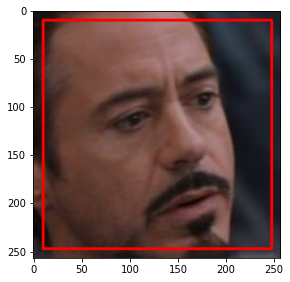

10 10 170 170
face without mask detected!


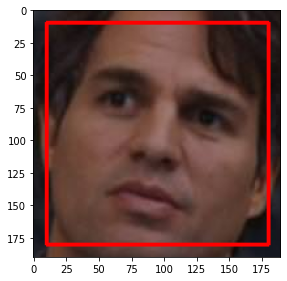

In [ ]:
counter = -1
print(len(predictions))
for (x,y,w,h) in faces:
  counter+=1
  roi = image[y:y+h, x:x+w]
  plt.figure(figsize=(10, 10))
  plt.subplot(2, 2, 1)
  x=10
  y=10
  w=len(roi)-20
  h=len(roi[0])-20
  print(x, y, w, h)
  if predictions[counter][0] > 0.5:
    print("face with mask detected!")
    cv2.rectangle(roi,(x,y),(x+w,y+h),(0,255,0),2) 
  else:
    print("face without mask detected!")
    cv2.rectangle(roi,(x,y),(x+w,y+h),(255,0,0),2) 
  plt.imshow(roi)
  img = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
  plt.show()

2


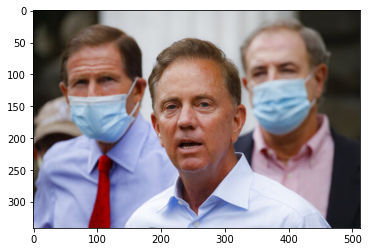

<Figure size 648x648 with 0 Axes>

In [ ]:
img_address = "drive/My Drive/preview.jpg"
image = cv2.imread(img_address)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
fig = plt.figure(figsize=(9,9))
image.shape
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
faces = face_cascade.detectMultiScale(image, 1.2, 2)

image_with_detections = image.copy()
imgs = []
for (x,y,w,h) in faces:
  roi = image[y:y+h, x:x+w]
  imgs.append(roi)

print(len(imgs))
scaled_image_1 = cv2.resize(imgs[0], (227, 227)) 
scaled_image_2 = cv2.resize(imgs[1], (227, 227))
# scaled_image_3 = cv2.resize(imgs[2], (227, 227)) 
# scaled_image_4 = cv2.resize(imgs[3], (227, 227))
# scaled_image_5 = cv2.resize(imgs[4], (227, 227)) 
# scaled_image_6 = cv2.resize(imgs[5], (227, 227)) 
news = []
news.append(scaled_image_1)
news.append(scaled_image_2)
# news.append(scaled_image_3)
# news.append(scaled_image_4)
# news.append(scaled_image_5)
# news.append(scaled_image_6)

In [ ]:
predictions = classifier.predict(np.array(news))

face with mask detected!
face without mask detected!


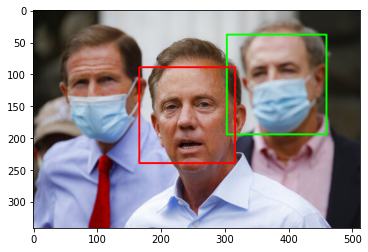

In [ ]:
img_address = "drive/My Drive/preview.jpg"
image = cv2.imread(img_address)

image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
counter = -1
for (x,y,w,h) in faces:
  counter+=1
  if predictions[counter][0] > 0.5:
    print("face with mask detected!")
    cv2.rectangle(image,(x,y),(x+w,y+h),(0,255,0),2) 
  else:
    print("face without mask detected!")
    cv2.rectangle(image,(x,y),(x+w,y+h),(255,0,0),2) 

plt.imshow(image)